# Paper Abstracts Clustering - 2nd

Author: Rafael Ballestiero

In [1]:
import os

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

plt.rcParams['figure.figsize']=[50,30]
plt.rcParams['font.size']=22
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24

In [2]:
from gensim import corpora


from gensim.models.phrases import Phrases
from gensim.models import HdpModel, KeyedVectors

from gensim.utils import has_pattern, simple_preprocess
from gensim.parsing import preprocessing
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, \
                                         strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short, stem_text

from gensim.similarities import WmdSimilarity, MatrixSimilarity
from gensim.summarization import keywords, summarize_corpus, summarize
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import get_tmpfile

from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import OneHotEncoder

from scipy import spatial
import scipy.cluster.hierarchy as shc

import pattern.en as en

assert has_pattern()

ModuleNotFoundError: No module named 'gensim'

## Clean

In [402]:
df = pd.read_csv("./data/text_allyears.csv", header=0, index_col=None, encoding = "cp1252").dropna(subset=["Abstract"])

In [461]:
def lemmatize(s):
    return " ".join([en.lemma(w) for w in s.split()])

cp1252_pattern = re.compile(u"“|”|’|‘|—")
def strip_cp1252_punctuation(s):
    return re.sub(cp1252_pattern, " ", s)

In [462]:
preprocessed_abstracts = df["Abstract"].apply(str).apply(preprocess_string, filters=[
    lambda x: x.lower(),
    strip_tags,
    strip_cp1252_punctuation,
    strip_punctuation, 
    strip_multiple_whitespaces, 
    strip_numeric, 
    remove_stopwords, 
    strip_short,
    lemmatize,
])

#### Convert GloVe to Word2Vec

In [128]:
def convert_glove_2_w2v():
    tmp_file = get_tmpfile("test_word2vec.txt")

    glove2word2vec("./data/glove.6B/glove.6B.50d.txt", tmp_file)

    return KeyedVectors.load_word2vec_format(tmp_file)
    
# model = convert_glove_2_w2v()

In [151]:
def calculate_distance_matrix():
    s = preprocessed_abstracts.size
    result = np.ndarray((s,s))
    
    for i, a1 in enumerate(preprocessed_abstracts):
        print(f"({i}/{s}) Calculating distance for abstract...")
        for j, a2 in enumerate(preprocessed_abstracts.iloc[i:]):
            distance = model.wmdistance(a1, a2)
            result[i][i + j] = distance
            result[i + j][i] = distance
            print(f"D_({i}, {i + j})={distance}")
            
    return result

abstract_distance_matrix = calculate_distance_matrix()

(0/302) Calculating distance for abstract...
D_(0, 0)=0.0
D_(0, 1)=3.412224064728752
D_(0, 2)=3.696563885093704
D_(0, 3)=3.1394404928548423
D_(0, 4)=3.2062193324073878
D_(0, 5)=3.861343228921628
D_(0, 6)=3.3083847313058037
D_(0, 7)=4.929240066538592
D_(0, 8)=3.618782149954167
D_(0, 9)=3.3479153939064163
D_(0, 10)=3.5394774925425
D_(0, 11)=3.143897982696416
D_(0, 12)=3.574007342040647
D_(0, 13)=3.7364546652357467
D_(0, 14)=3.3276567058316013
D_(0, 15)=2.6302057590925494
D_(0, 16)=3.9142944713994514
D_(0, 17)=3.38742329225901
D_(0, 18)=3.3397012314695154
D_(0, 19)=3.374981948822083
D_(0, 20)=3.382535538013454
D_(0, 21)=3.3715851804067234
D_(0, 22)=3.115705205267103
D_(0, 23)=3.255735387847866
D_(0, 24)=3.486218746063637
D_(0, 25)=3.3076189345684686
D_(0, 26)=3.1738143785160515
D_(0, 27)=3.58006079423827
D_(0, 28)=3.1701300097875915
D_(0, 29)=2.9791454158591586
D_(0, 30)=2.963154164115245
D_(0, 31)=3.9071390064170153
D_(0, 32)=3.0409442714260058
D_(0, 33)=4.274805674470468
D_(0, 34)=3.136

In [430]:
# remove nan abstract 
# abstract_distance_matrix = np.delete(abstract_distance_matrix, 158, 1)
# abstract_distance_matrix = np.delete(abstract_distance_matrix, 158, 0)

In [469]:
# pd.DataFrame(abstract_distance_matrix).to_csv('data/allyears_distance_matrix.csv')
abstract_distance_matrix = pd.read_csv('data/allyears_distance_matrix.csv', index_col=0).values
abstract_df = spatial.distance.squareform(abstract_distance_matrix)

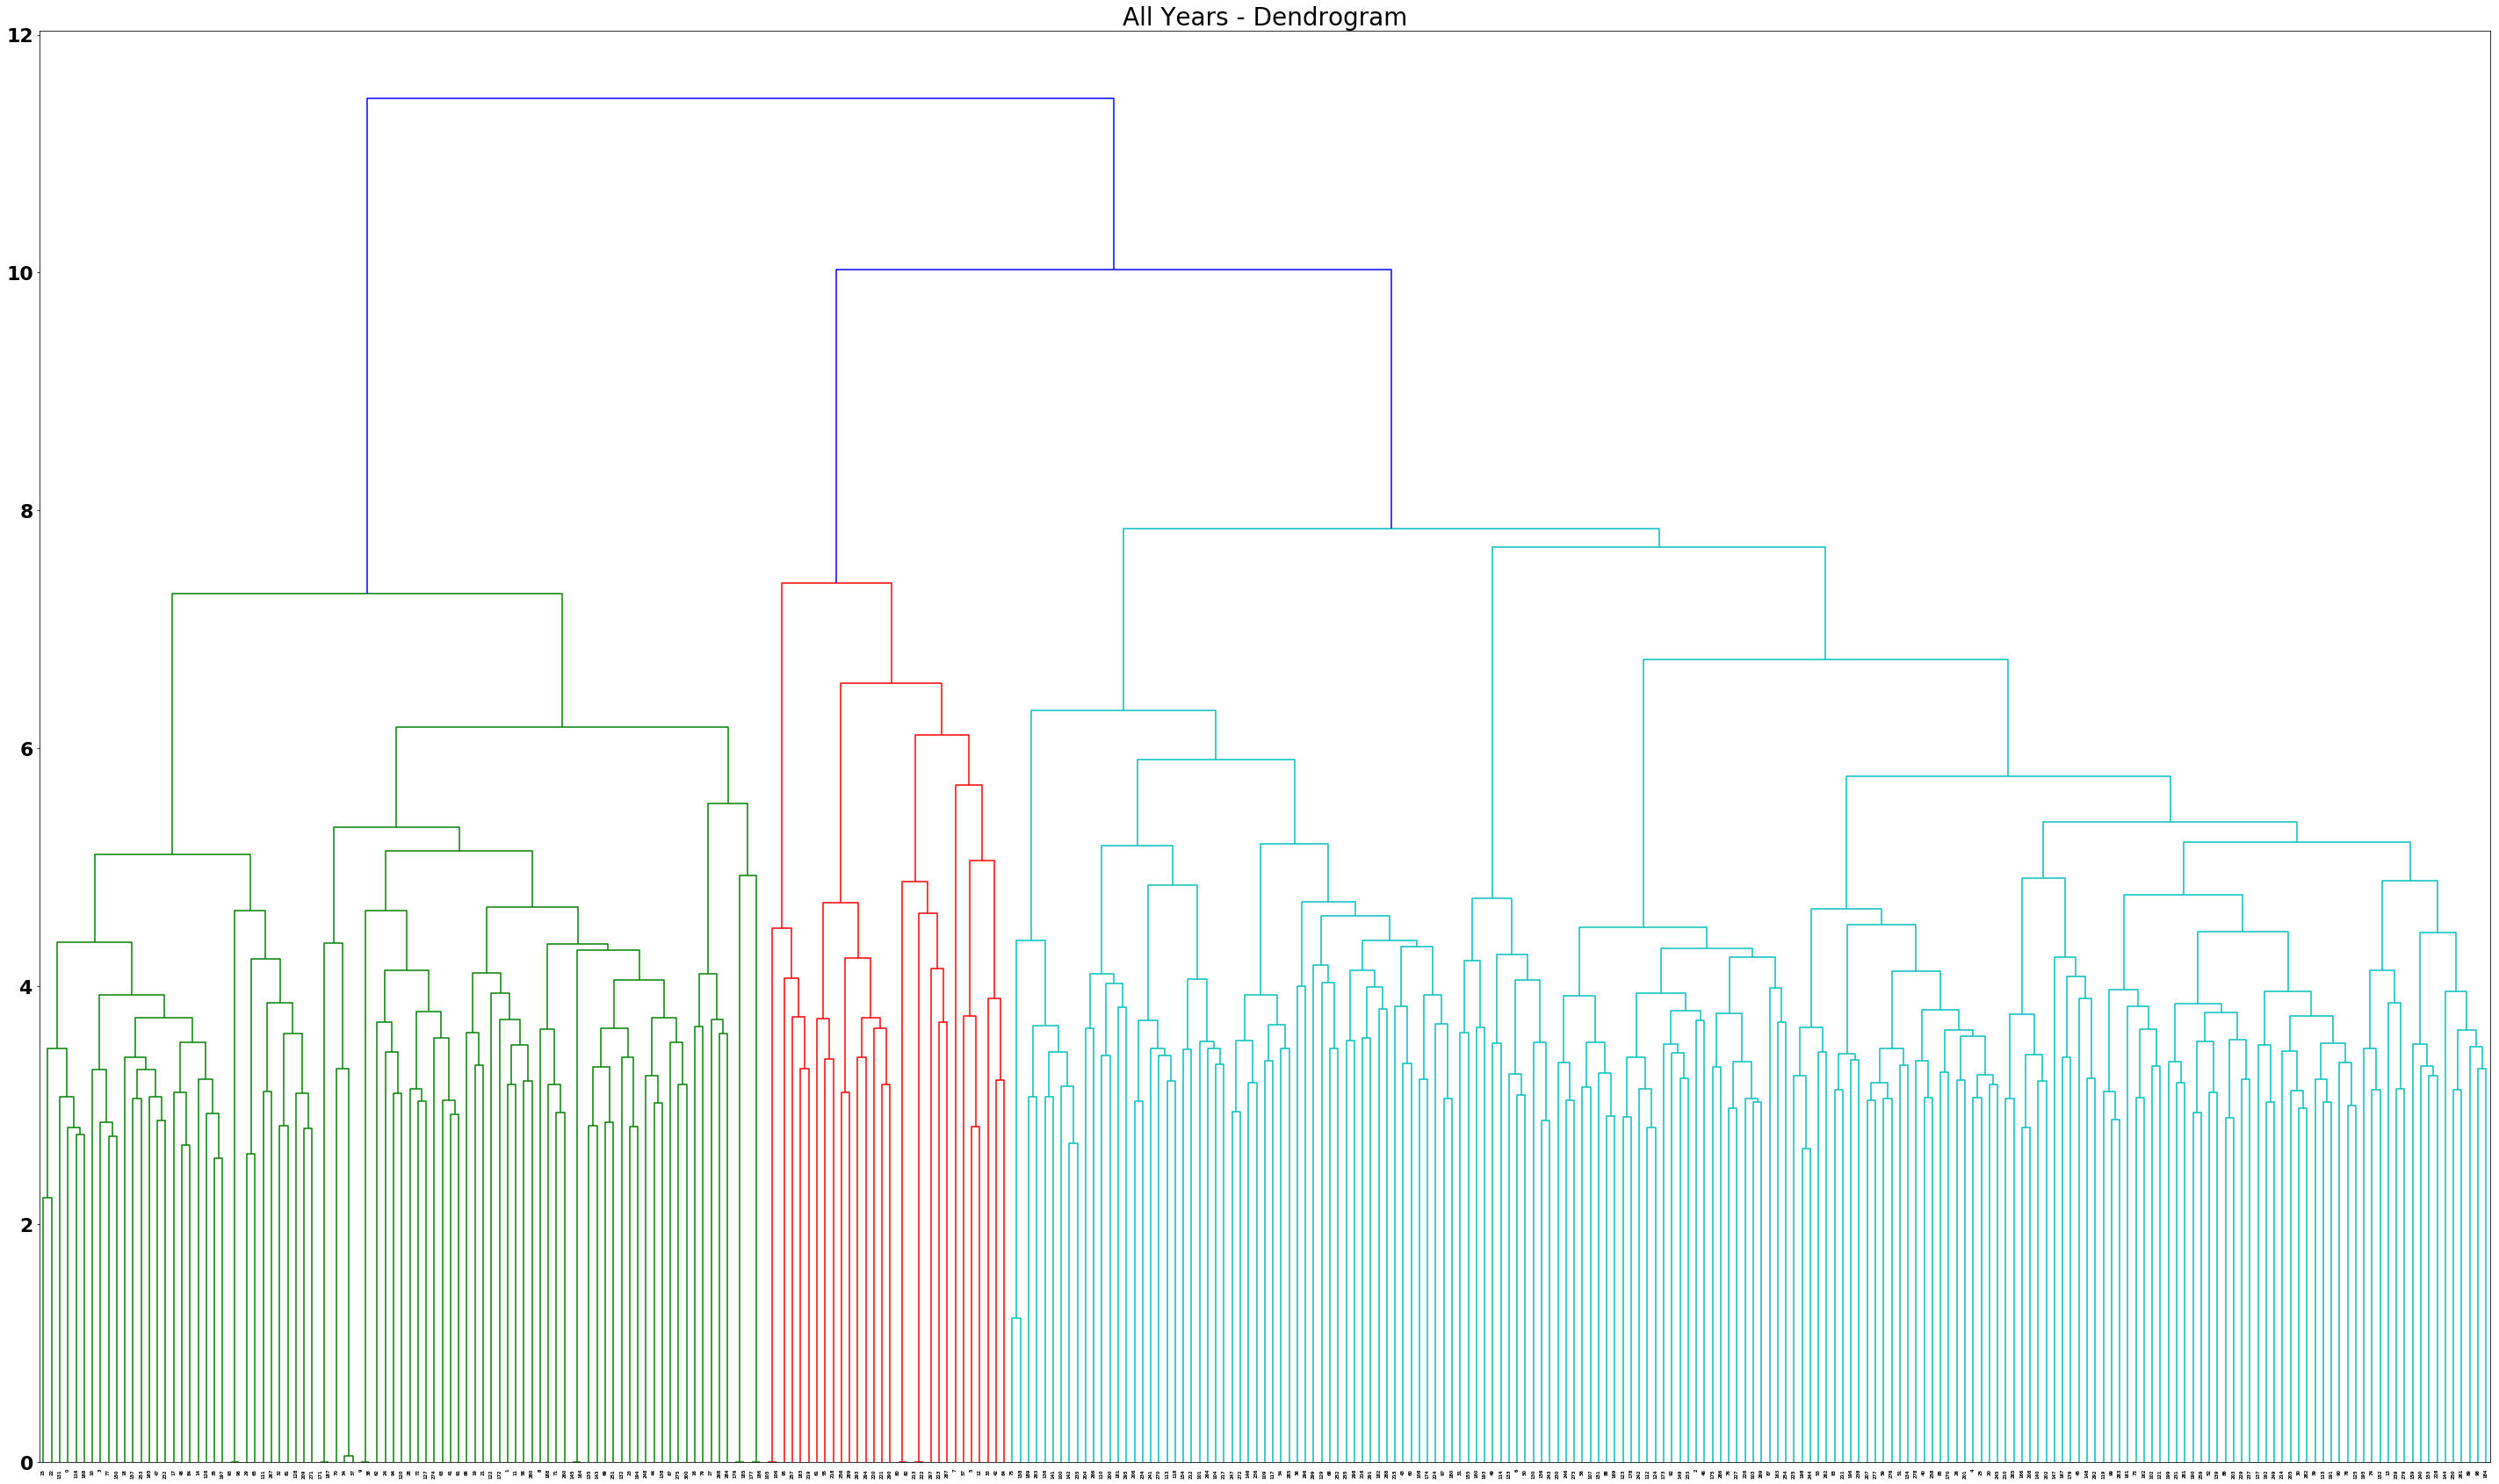

In [470]:
plt.title("All Years - Dendrogram")
dend = shc.dendrogram(shc.linkage(abstract_df, method='ward'))
plt.savefig('plots/dendrograms/allyears_dendrogram.pdf', format='pdf')

In [439]:
def cluster(X, n_clusters):
    return shc.fcluster(shc.linkage(X, method='ward'), n_clusters, criterion='maxclust')

In [471]:
def silhouette_evaluation(X, n_clusters, name, squareform=False):
    fig, ax1 = plt.subplots(figsize=(30, 15))

    clusters = cluster(X, n_clusters)
    
    if squareform:
        X = spatial.distance.squareform(X)

    silhouette_avg = silhouette_score(X, clusters, sample_size=None)
    samples = silhouette_samples(X, clusters)

    y_lower = 10
    for i in range(1, n_clusters + 1):
        cluster_silhouette_scores = samples[clusters == i]
        cluster_silhouette_scores.sort()

        cluster_size = cluster_silhouette_scores.shape[0]
        y_upper = y_lower + cluster_size

        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_scores)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * cluster_size, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title(f'Silhouette Graph (k={n_clusters}) - {name}')

    ax1.set_yticks([])
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.text(silhouette_avg + 0.01,20,f'silhouette_avg={np.round(silhouette_avg, 4)}')
    plt.savefig(f'plots/silhouette/{name}/silhouette_{n_clusters}')
    plt.show()

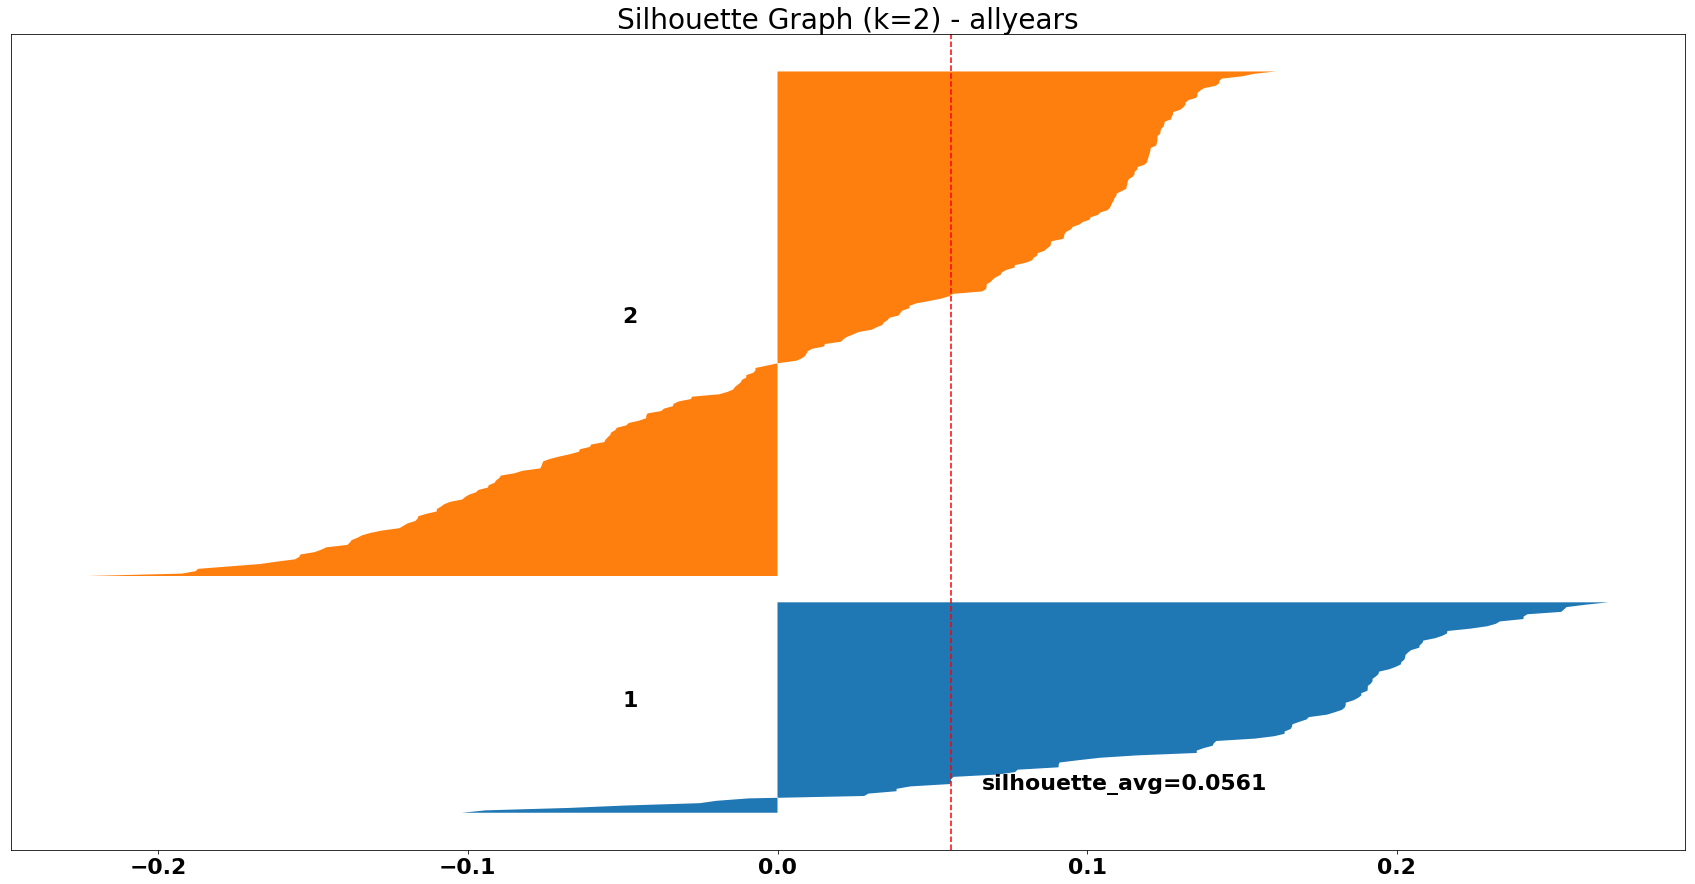

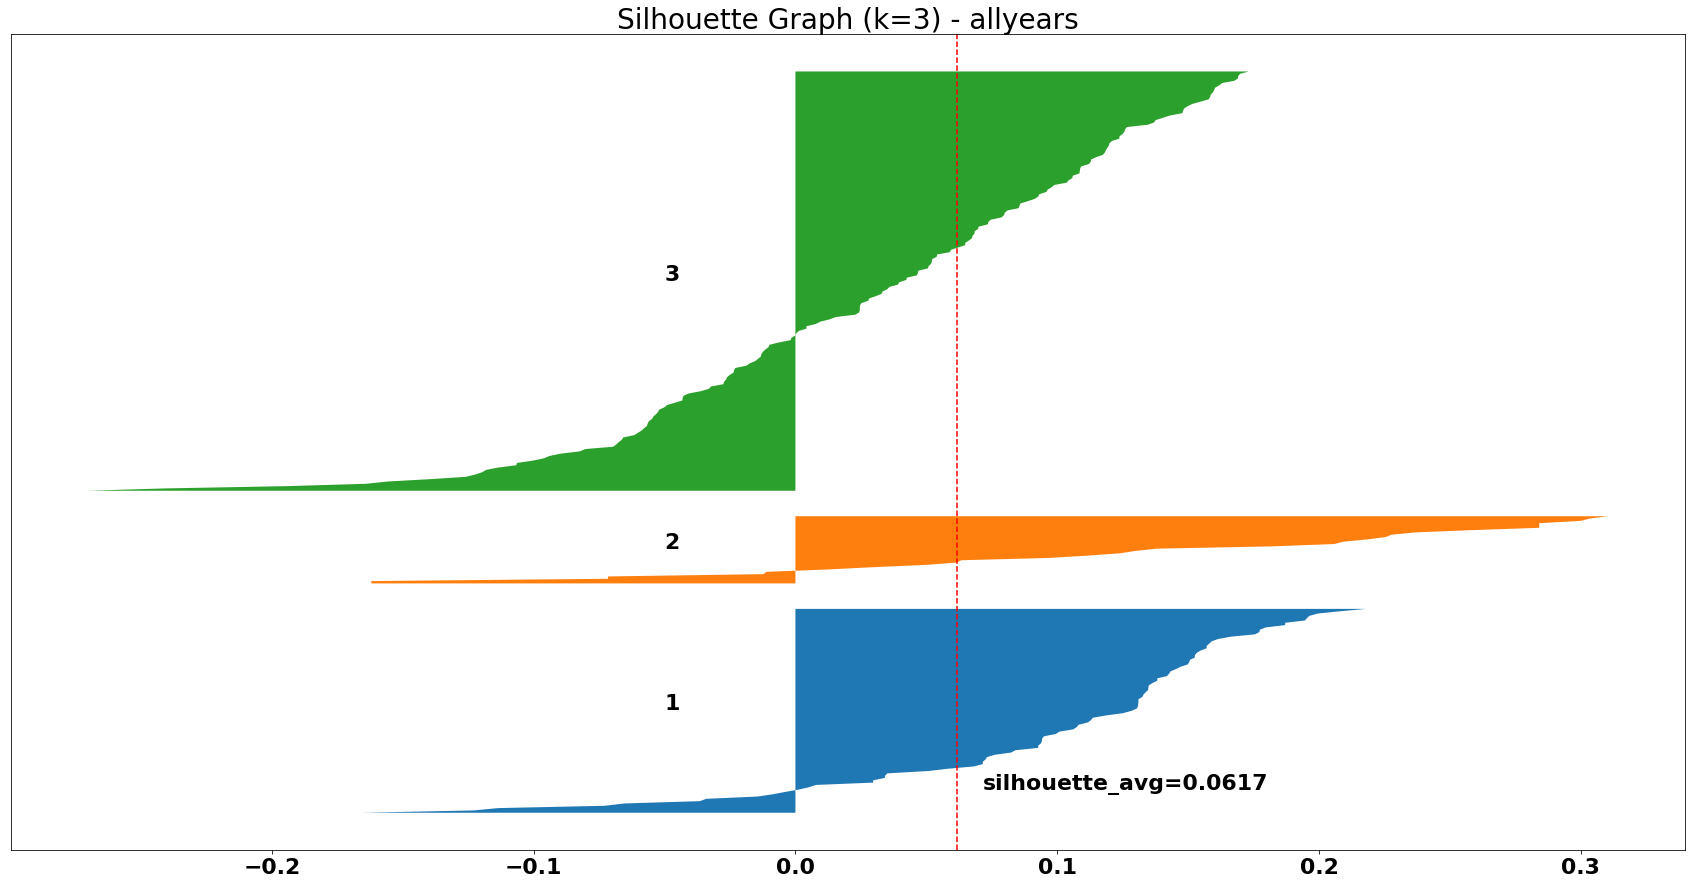

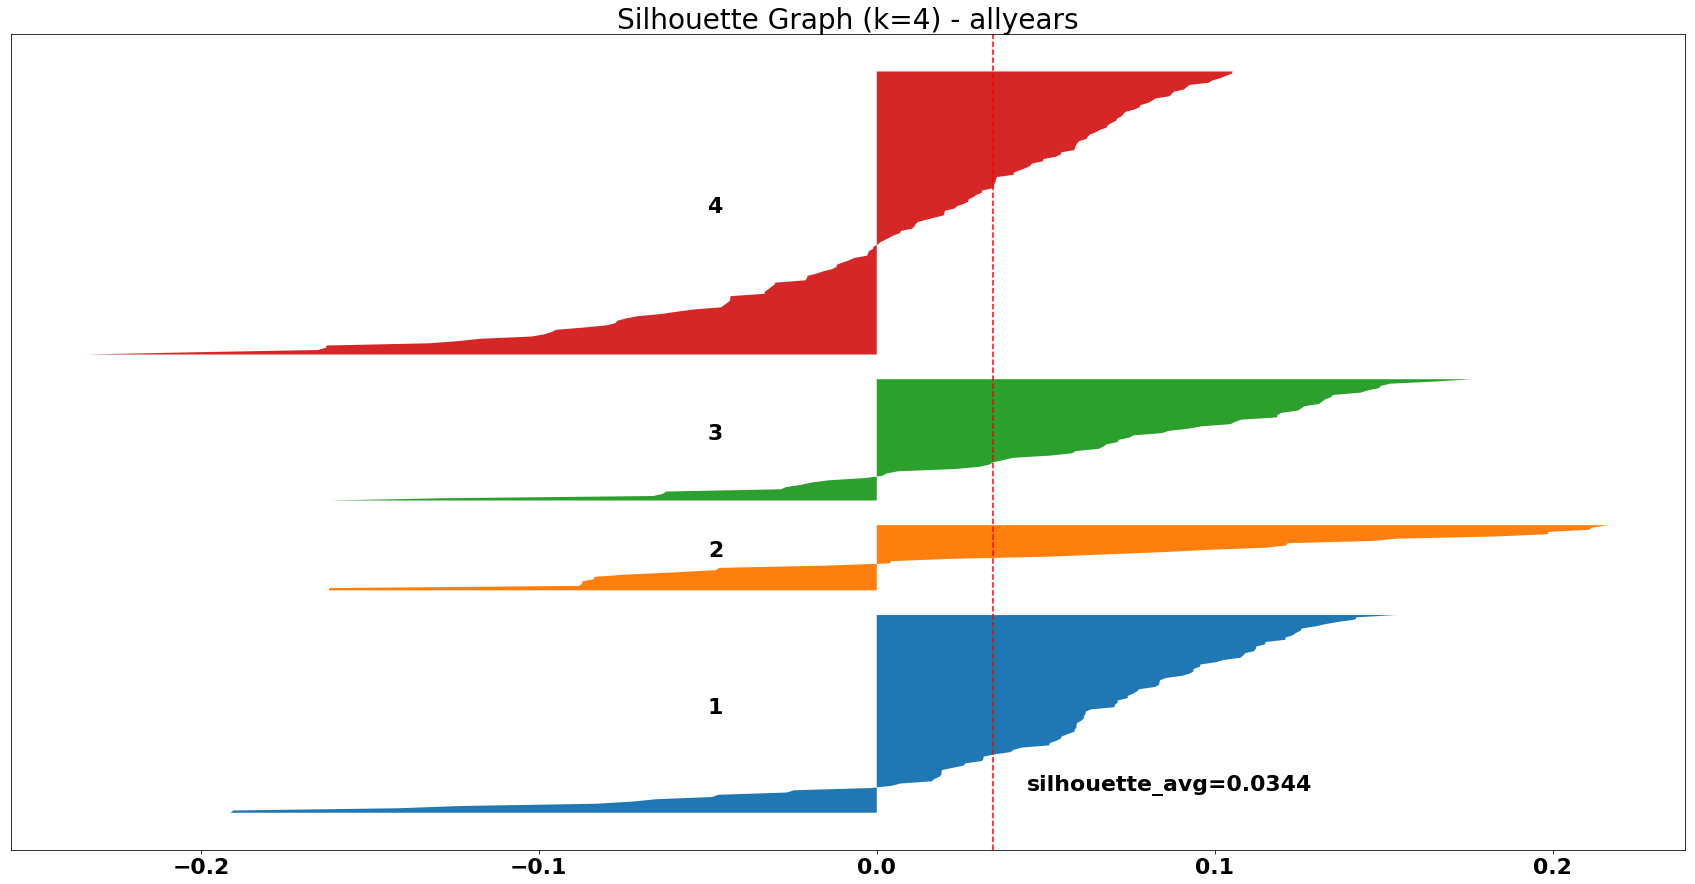

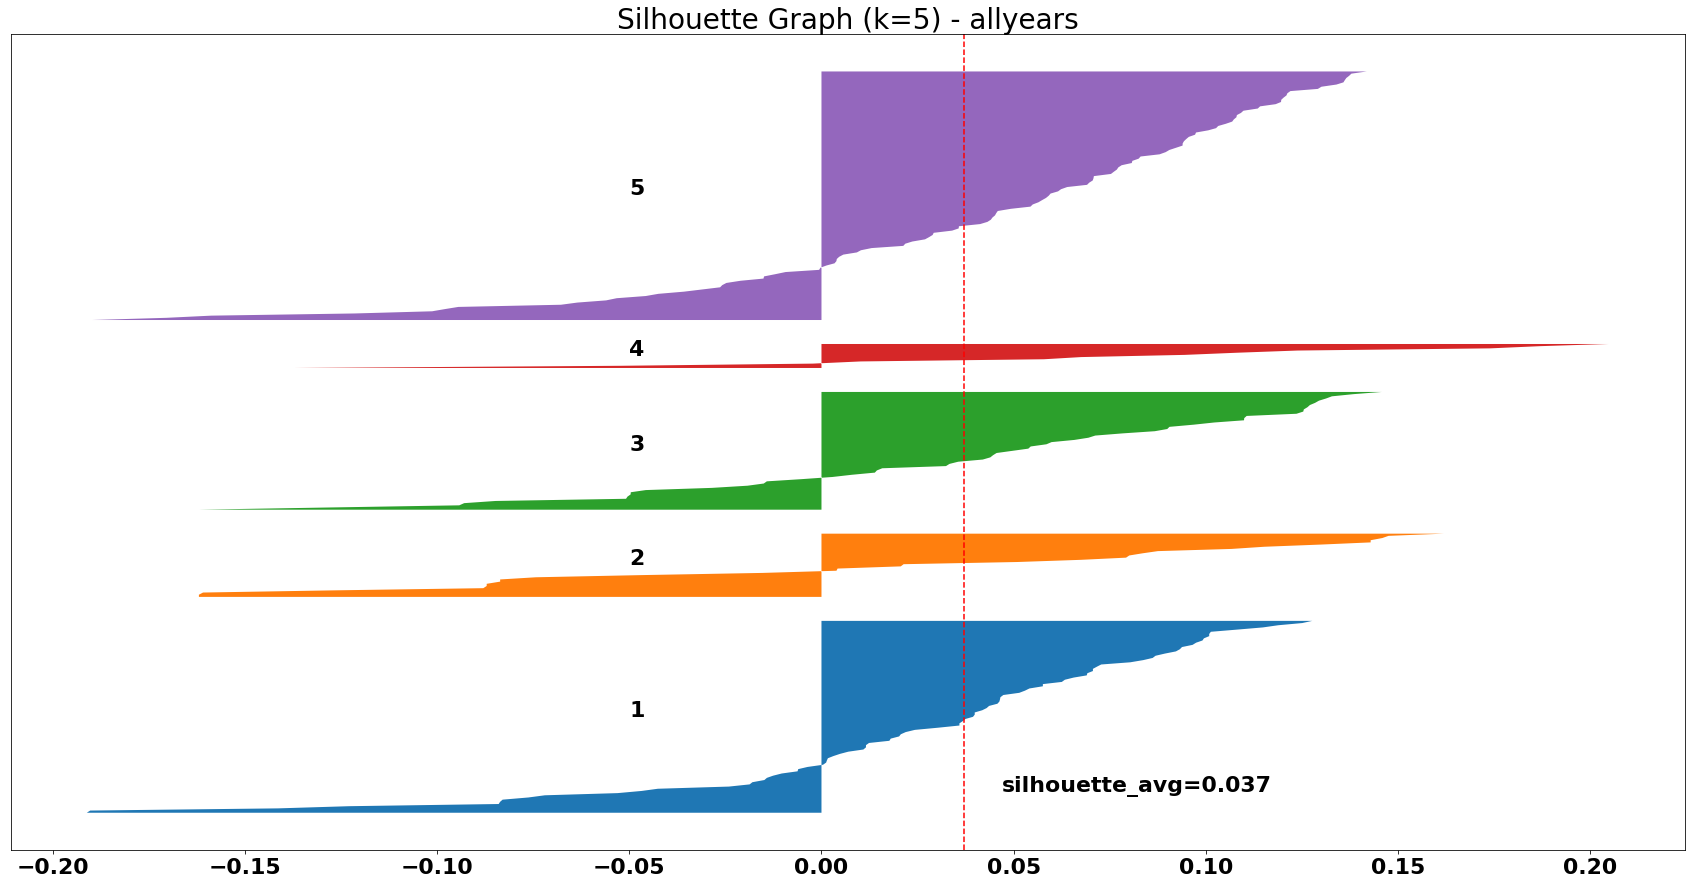

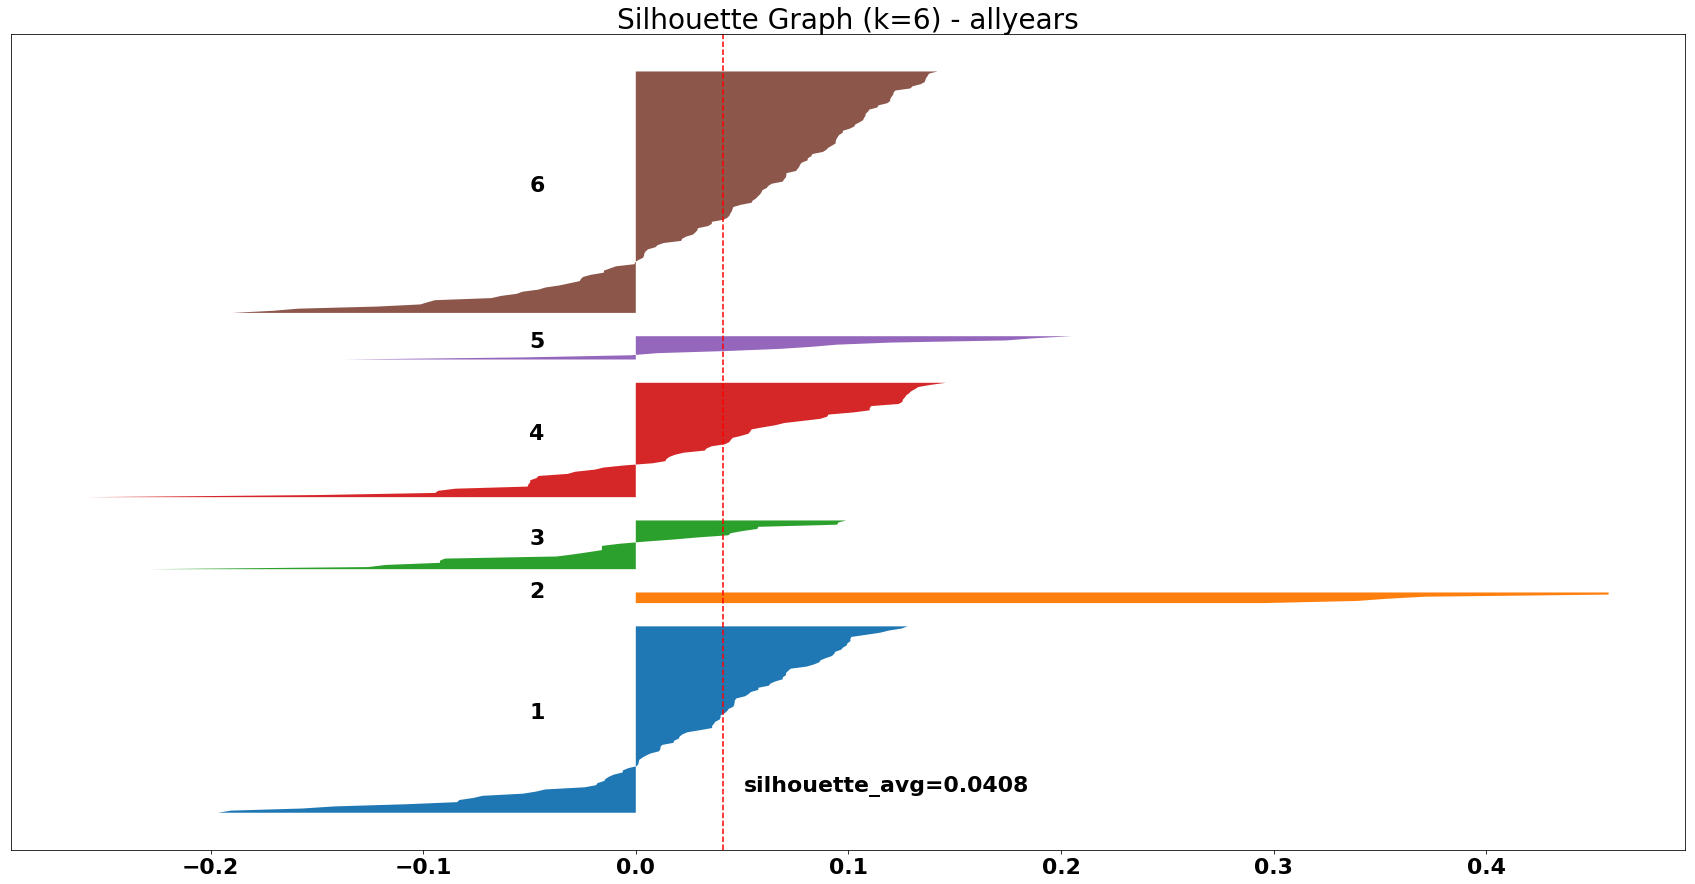

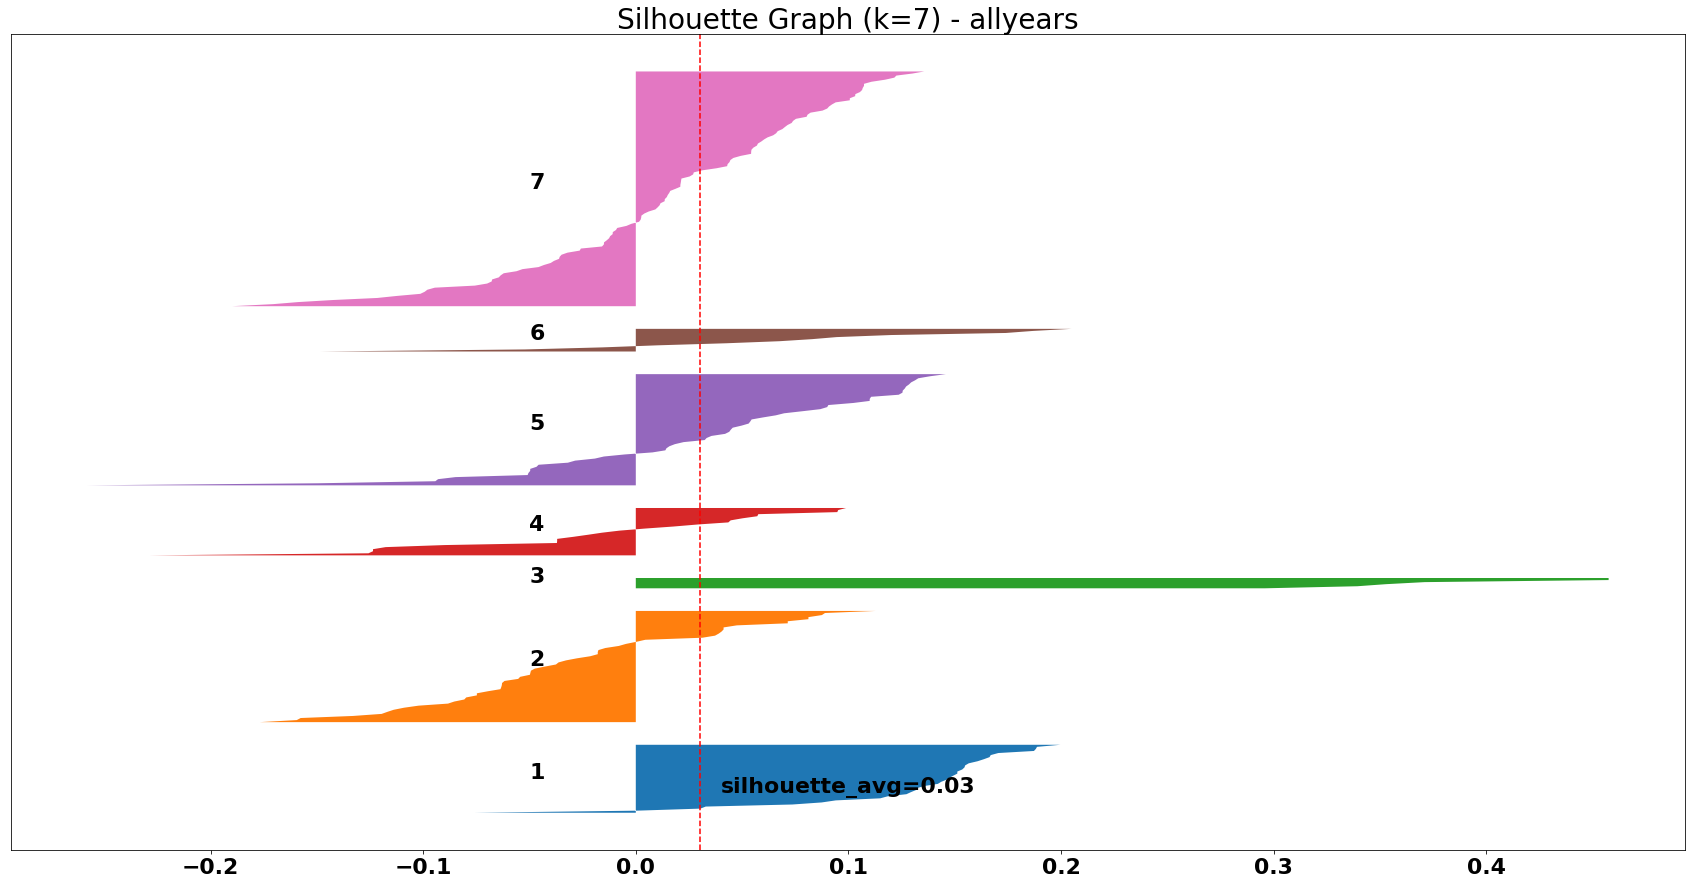

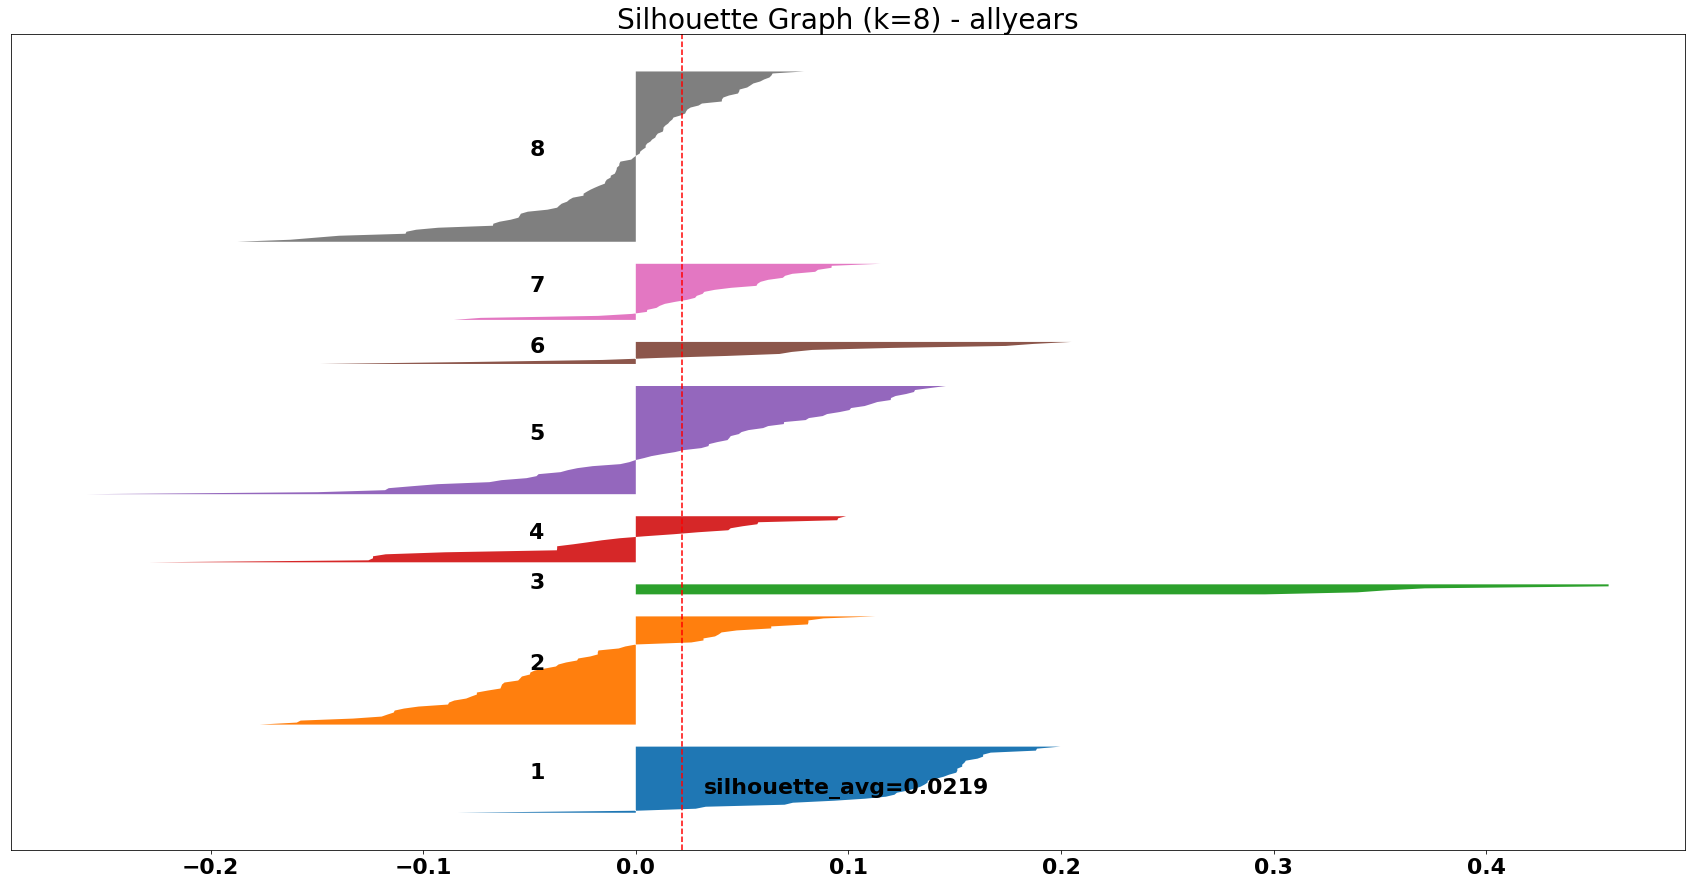

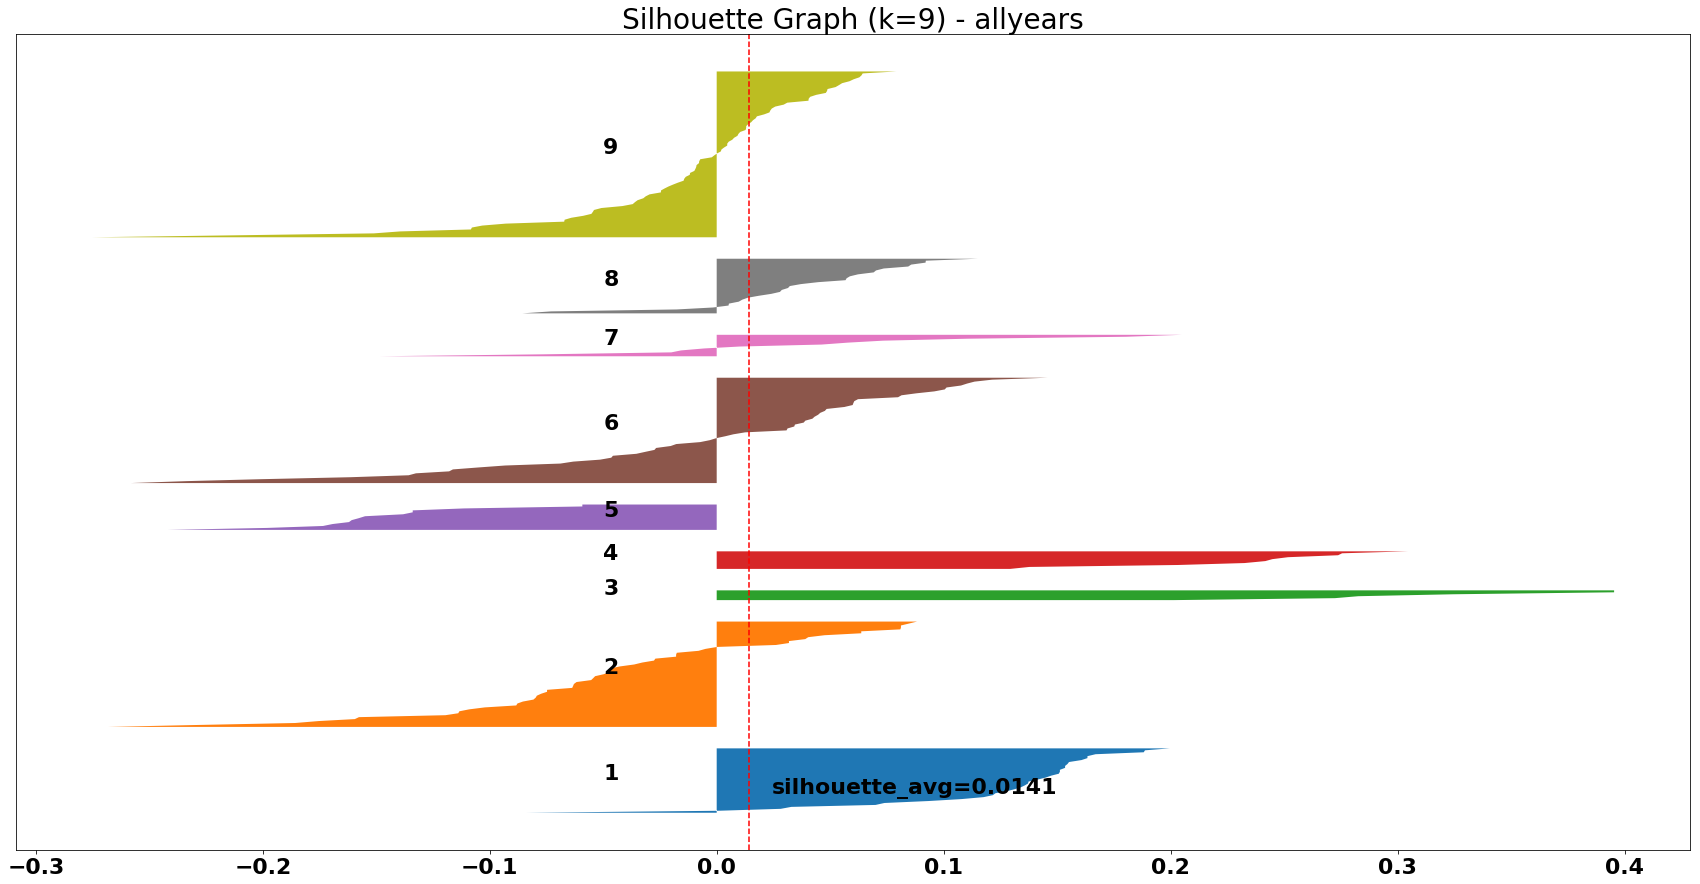

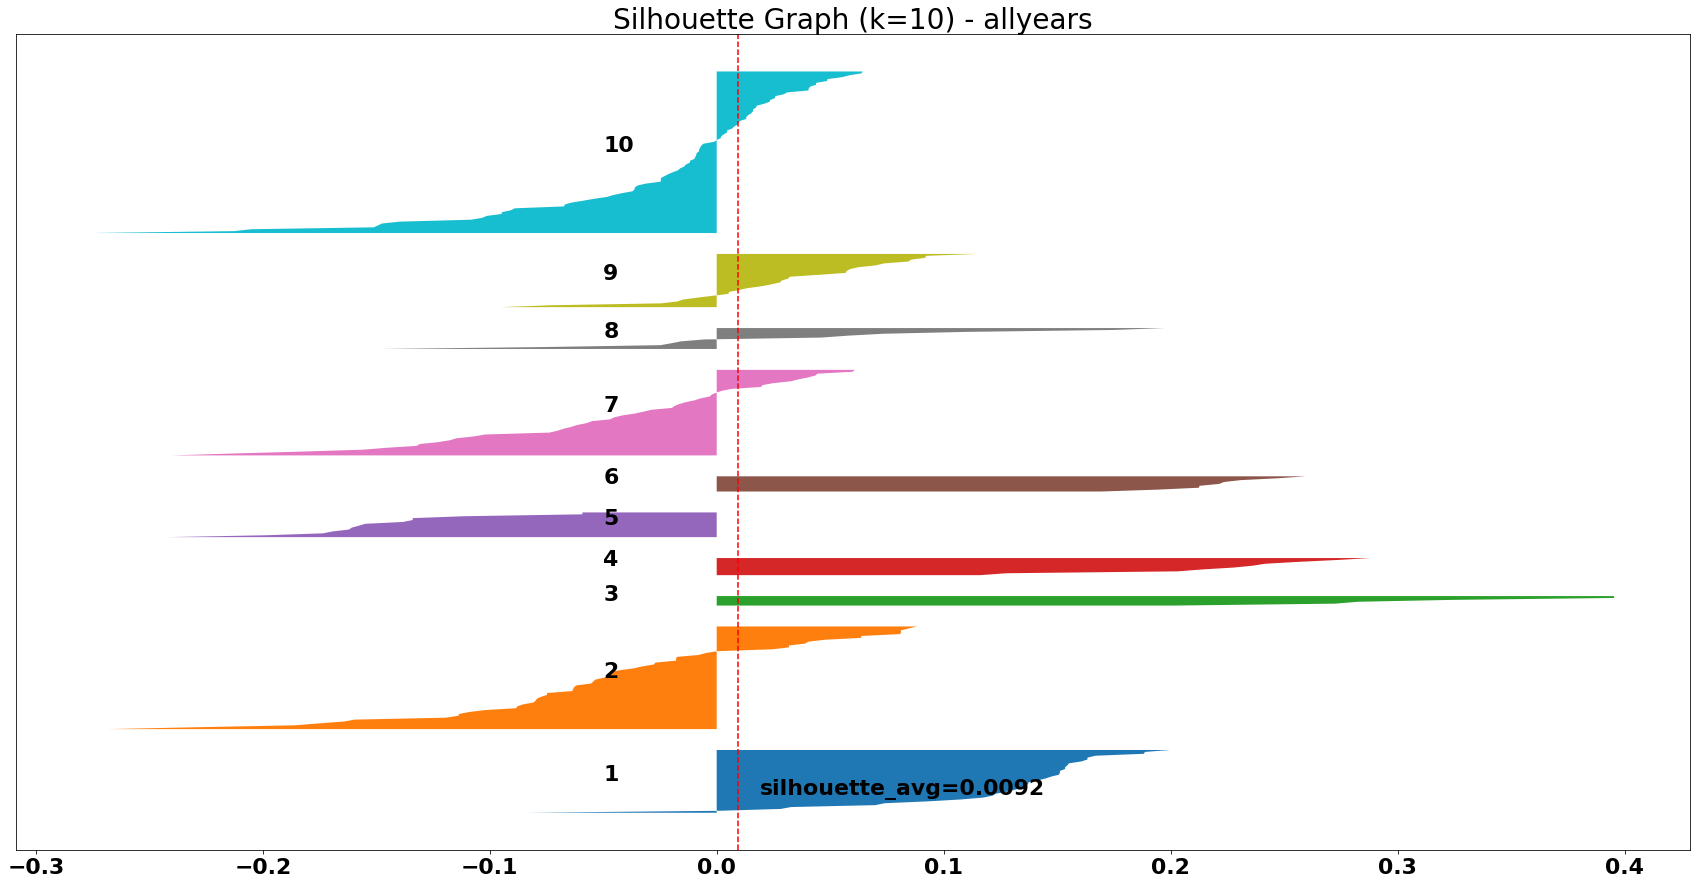

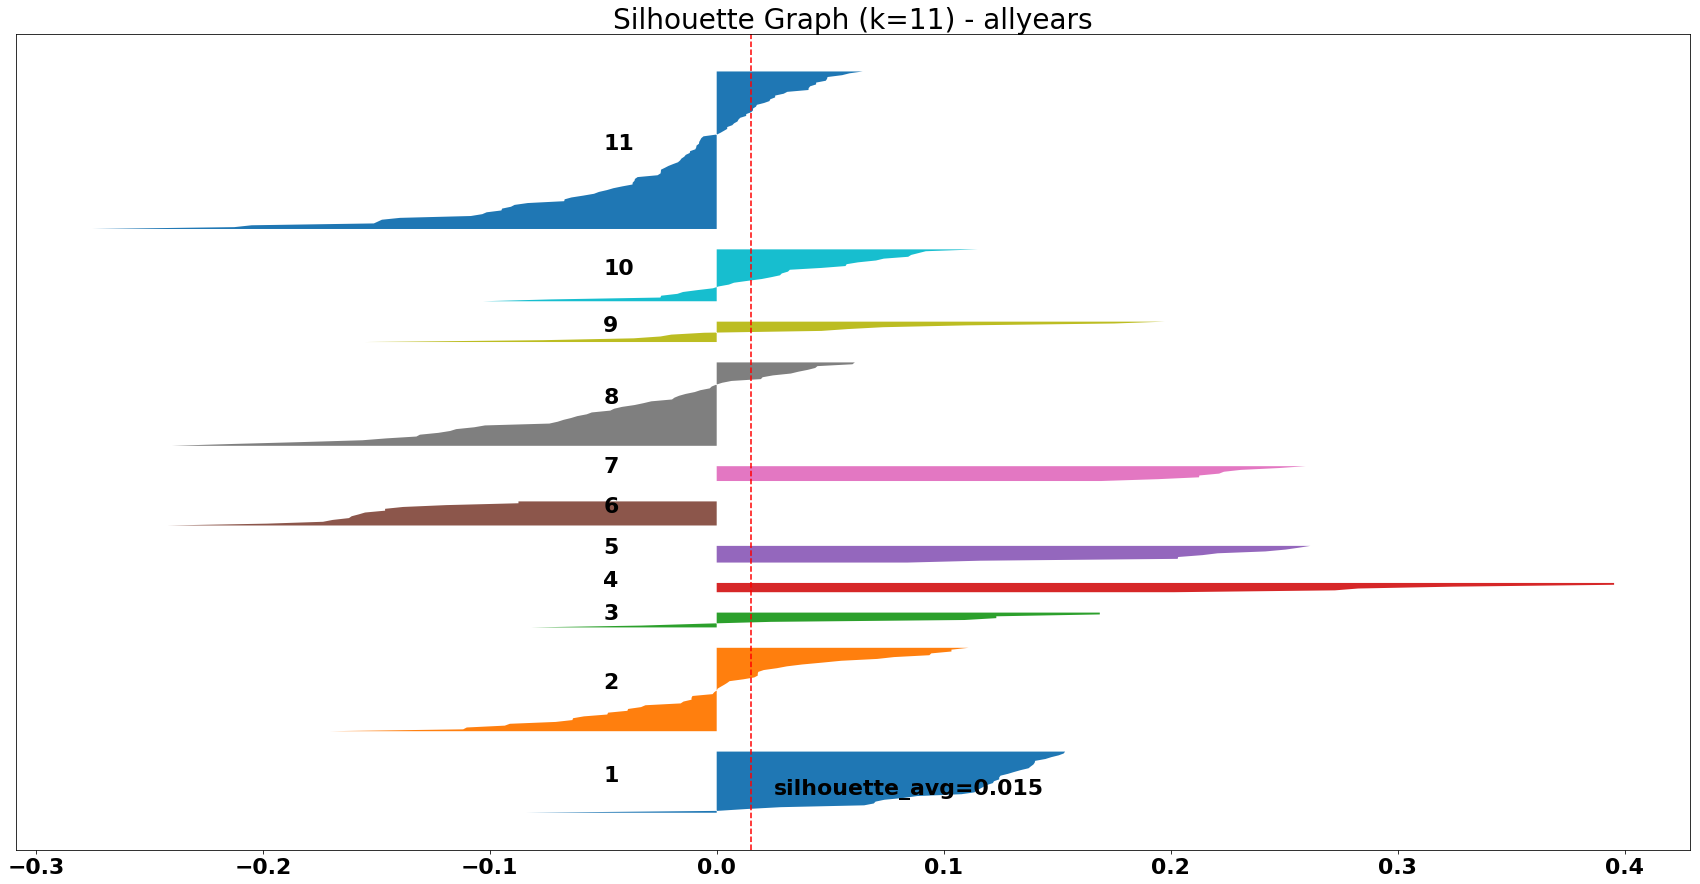

In [472]:
for i in range(2, 12):
    silhouette_evaluation(abstract_df, i, "allyears", True)

In [501]:
def cluster_keyword_scores(clusters, score_threshold=0.1, common_words=[]):
    result = []
    
    scored_keywords = preprocessed_abstracts.apply(" ".join)\
                                            .apply(lambda s: re.sub(u"-", " ", s))\
                                            .apply(stem_text)\
                                            .groupby(clusters)\
                                            .apply(" ".join)\
                                            .apply(lambda x: keywords(x, scores=True, words=6, split=True))

    for i, (group, kw_list) in enumerate(scored_keywords.iteritems()):
        for keyword, score in kw_list:
            result.append((group, keyword, score))
            
    return pd.DataFrame(result, columns=["cluster", "keyword", "score"])

In [502]:
def plot_cluster_keywords(X, n_clusters, title, **kwds):
    X_scores = cluster_keyword_scores(cluster(X, n_clusters), **kwds)
    
    fig, axes = plt.subplots(nrows=n_clusters, sharey=True)
        
    fig.suptitle(title, fontsize=35)
    fig.set_figheight(50)
    
    for i, ax in enumerate(axes):
        cluster_num = i + 1
        
        sns.barplot(
            x='keyword',  
            y='score',  
            data=X_scores[X_scores['cluster'] == cluster_num],
            ax=ax
        )

        ax.set_title(f"cluster={cluster_num}")
        ax.set_xlabel(None)
        ax.tick_params(axis='x', labelsize=40)
        
    
    fig.savefig(f'plots/keywords/{title}.pdf', format='pdf')
    

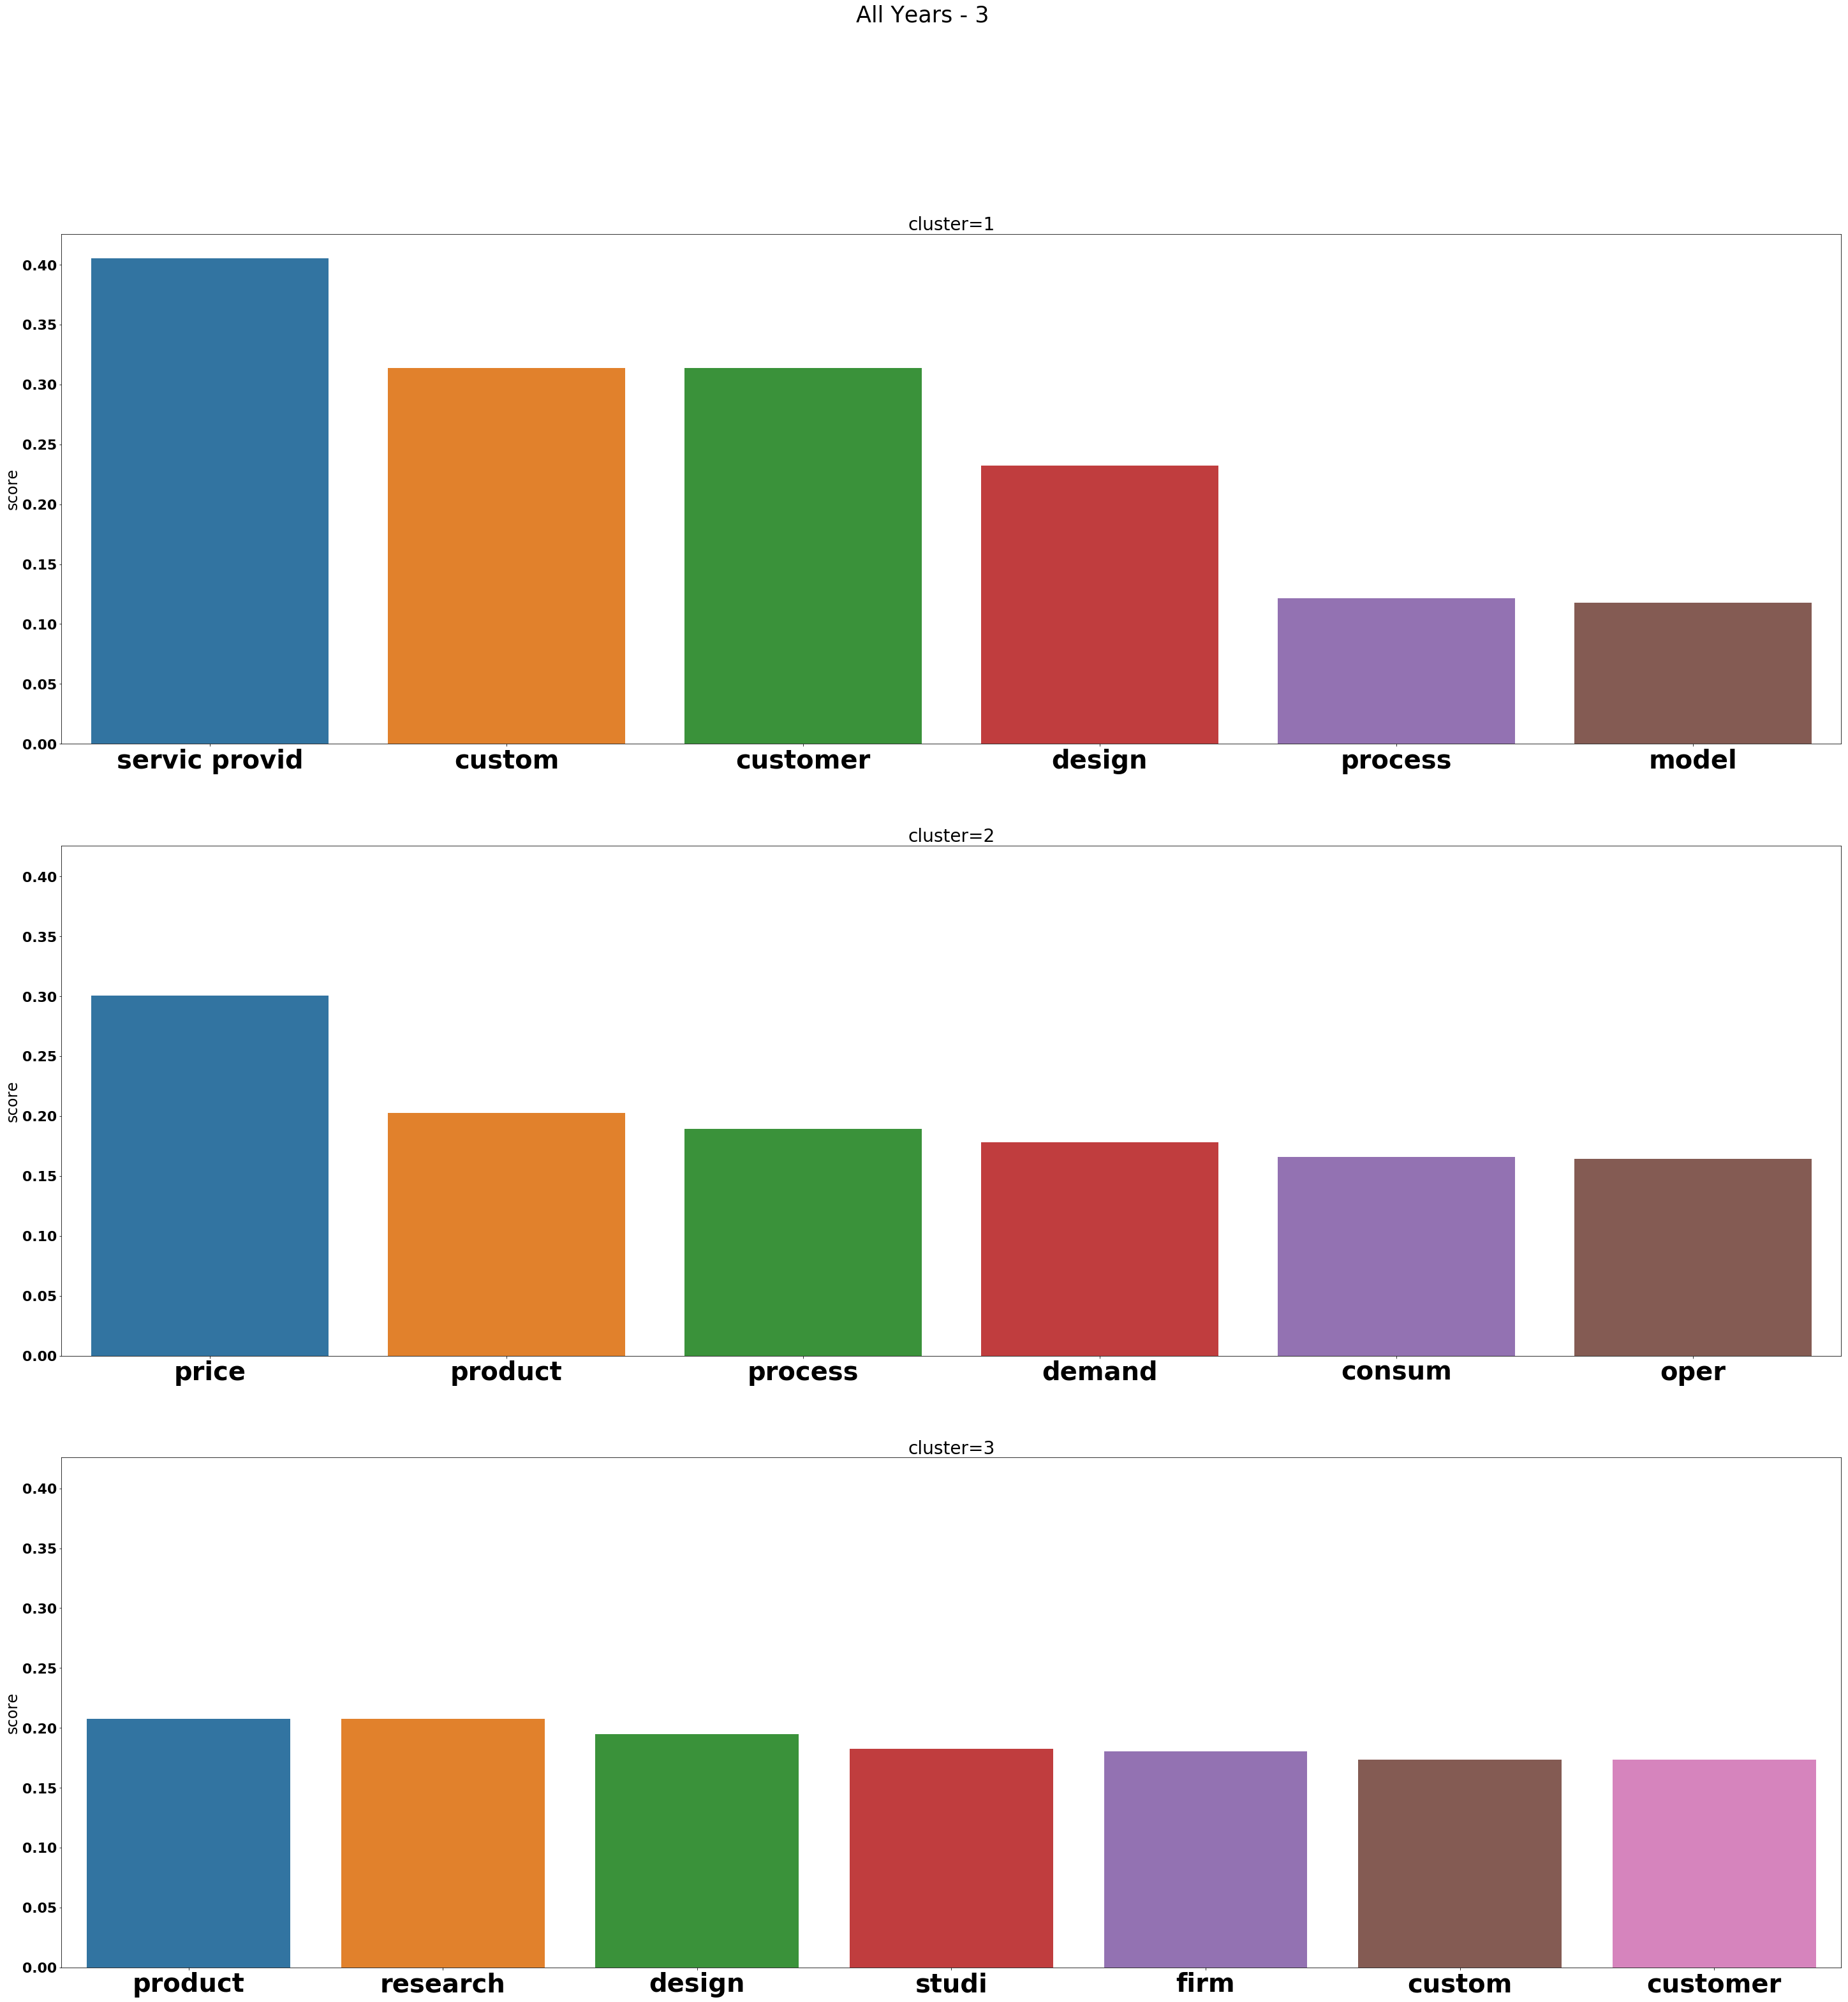

In [503]:
plot_cluster_keywords(abstract_df, 3, "All Years - 3")

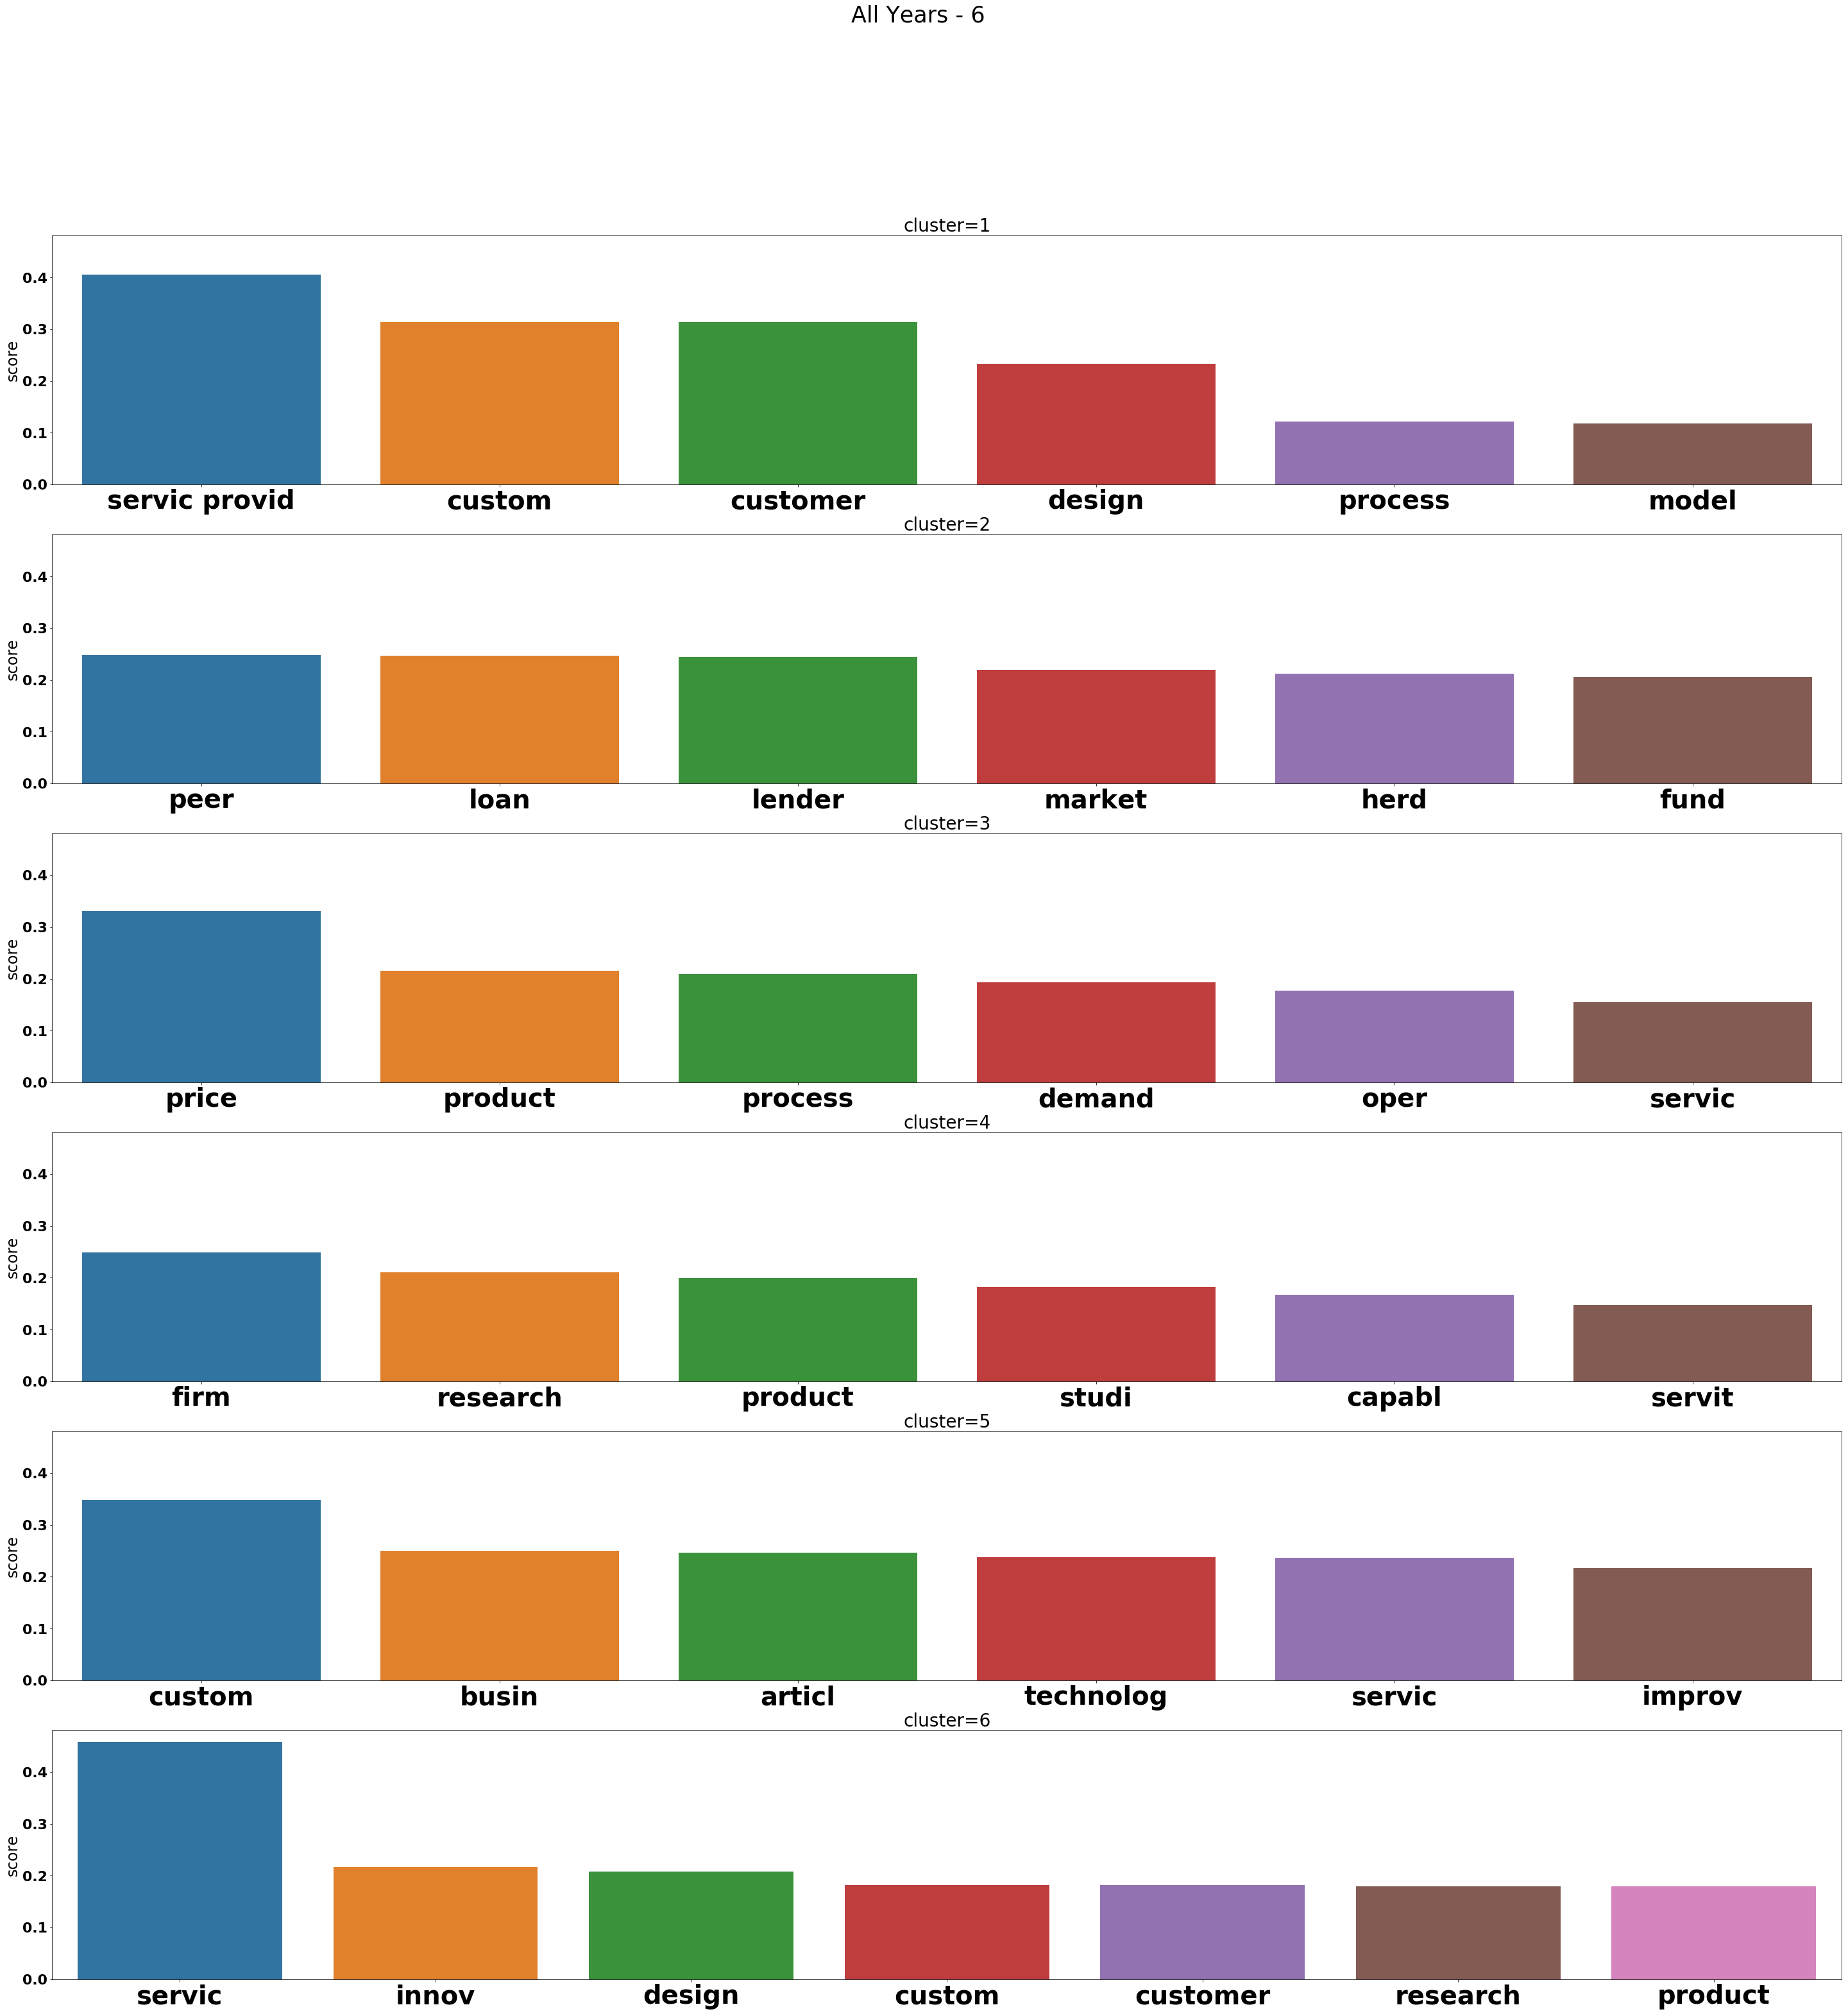

In [504]:
plot_cluster_keywords(abstract_df, 6, "All Years - 6")

In [477]:
df["cluster_6"] = cluster(abstract_df, 6)
df["cluster_3"] = cluster(abstract_df, 3)

In [505]:
df.to_csv('data/all_papers_with_clusters.csv')